Creating pose landmarks detector

In [1]:
%pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import mediapipe as mp
from time import time
import matplotlib.pyplot as plt
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.10.18, it should be 0.8.9.1


In [ ]:
# Make sure jupyterlab is running on the desired env
import sys
sys.executable.split('/')

['d:\\python 3.11\\python.exe']

Initialize the Pose Detection Model

In [ ]:
# Initializing mediapipe pose class
mp_pose = mp.solutions.pose

# Set up the pose landmarks function for imgs
pose_images = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True,
                           min_detection_confidence=0.8)

# Set up the pose landmarks function for videos.
pose_videos = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True,
                           enable_segmentation=True, smooth_segmentation=True, 
                           min_detection_confidence=0.5, min_tracking_confidence=0.8)

# Initialize the mediapipe drawing class
mp_drawing = mp.solutions.drawing_utils

# Initialize the mediapipe drawing styles class
mp_drawing_styles = mp.solutions.drawing_styles

Create a Pose Landmarks Detection function

In [ ]:
def detectPoseLandmarks(image, pose, draw=True, display=True):
    '''
    This function performs pose landmarks detection on an image.
    Args:
        image:   The input image with a prominent person whose pose landmarks needs to be detected.
        pose:    The Mediapipe's pose landmarks detection function required to perform the pose detection.
        draw:    A boolean value that is if set to true the function draws the detected landmarks on the output image. 
        display: A boolean value that is if set to true the function displays the original input image, the segmentation mask, 
                 the resultant image, and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image:   The input image with the detected pose landmarks drawn.
        pose_landmarks: An array containing the detected landmarks (x and y coordinates) converted into their original scale.
    '''
    
    # Retrieve the height and width of input image
    height, width, _ = image.shape
    
    # Create a copy of input image
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the pose landmarks detection on image
    results = pose.process(imageRGB)
    
    # Initialize a list to store the pose landmarks
    pose_landmarks = []
    
    # Initialize a variable to store the segmentation mask
    segmentation_mask = np.zeros(shape=(height, width), dtype=np.uint8)
    
    # Check if any landmarks are found
    if results.pose_landmarks:
        
        # Get the segmentation mask of the person detected in the image
        segmentation_mask = results.segmentation_mask
        
        # Convert the pose landmarks x and y coordinates into their original scale,
        # store them into a numpy array
        pose_landmarks = np.array([(landmark.x*width, landmark.y*height)
                                    for landmark in results.pose_landmarks.landmark], dtype=np.int32)
                
        # Check if pose landmarks are specified to be drawn
        if draw:
            
            # Draw pose landmarks on the output image
            mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                      connections=mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=mp_drawing_styles.
                                      get_default_pose_landmarks_style())
    
    # Check if the original input image, the segmentation mask, and the resultant image are specified to be displayed
    if display:

        # Display the original input image, the segmentation mask, and the resultant image
        plt.figure(figsize=[22,22])
        plt.subplot(131);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(132);plt.imshow(segmentation_mask, cmap='gray');plt.title("Segmentation Mask");plt.axis('off');
        plt.subplot(133);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');


        # plot the pose landmarks in 3D
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    
    else:

        return output_image, pose_landmarks

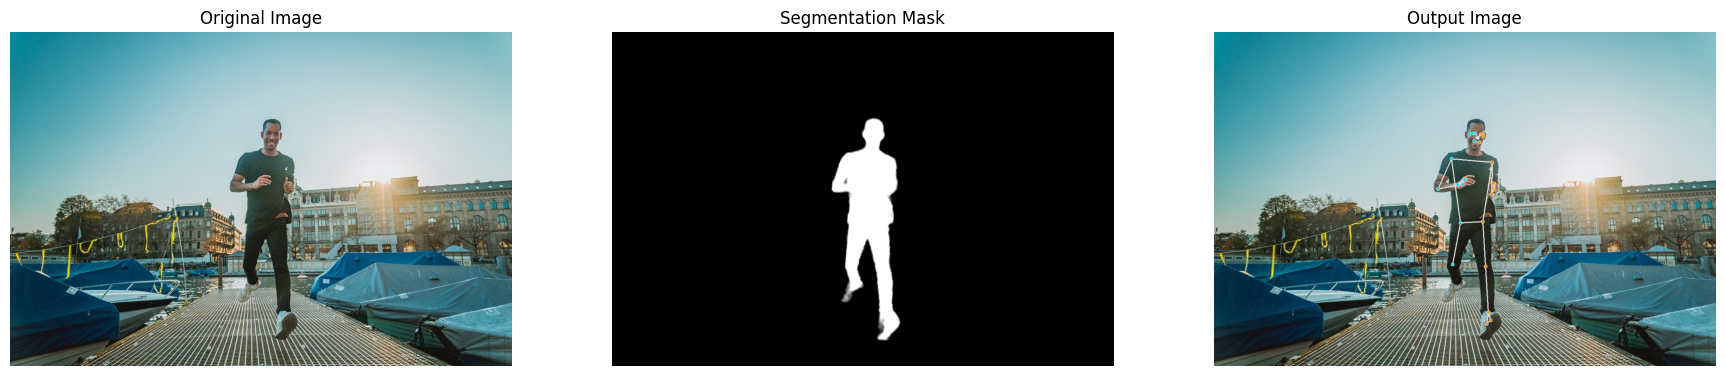

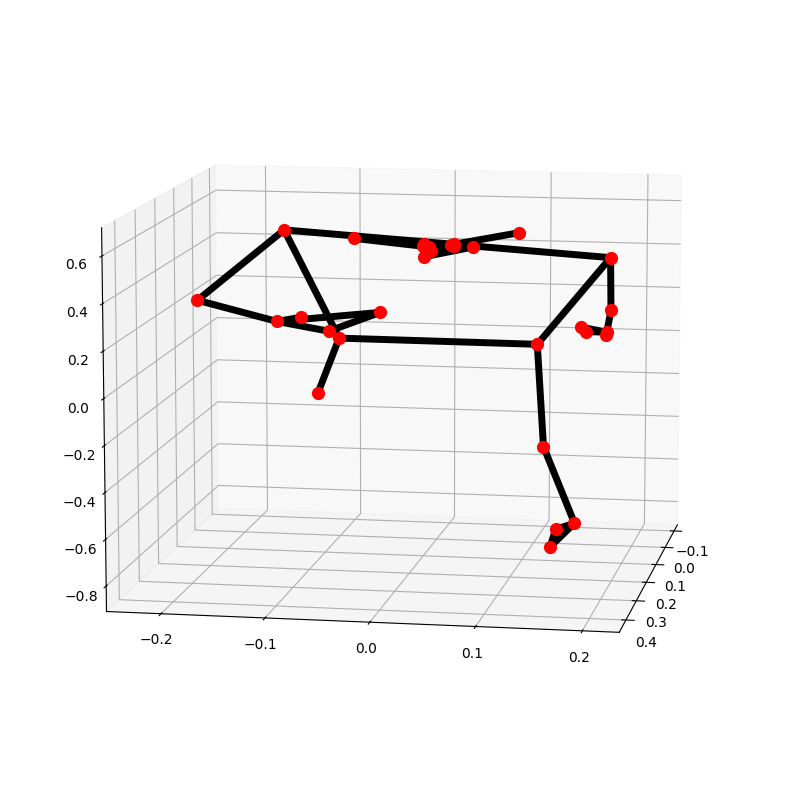

In [ ]:
# Read a sample image and perform pose detection on it
image = cv2.imread('D:\PracAI Assignment\media\sample1.jpg')
detectPoseLandmarks(image, pose_images, display=True)

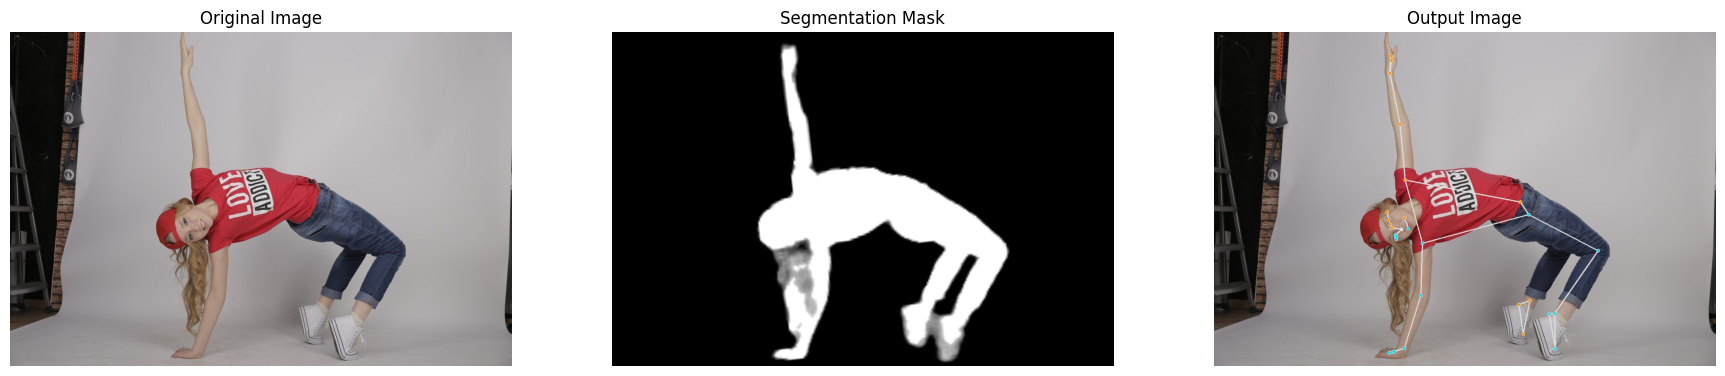

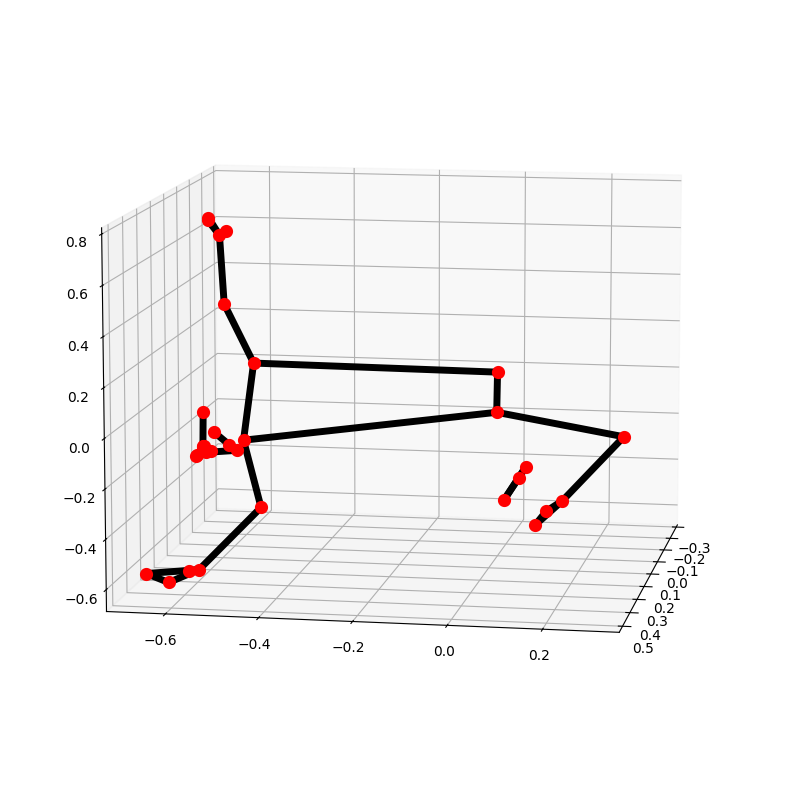

In [ ]:
image = cv2.imread('D:\PracAI Assignment\media\sample2.jpg')
detectPoseLandmarks(image, pose_images, display=True)

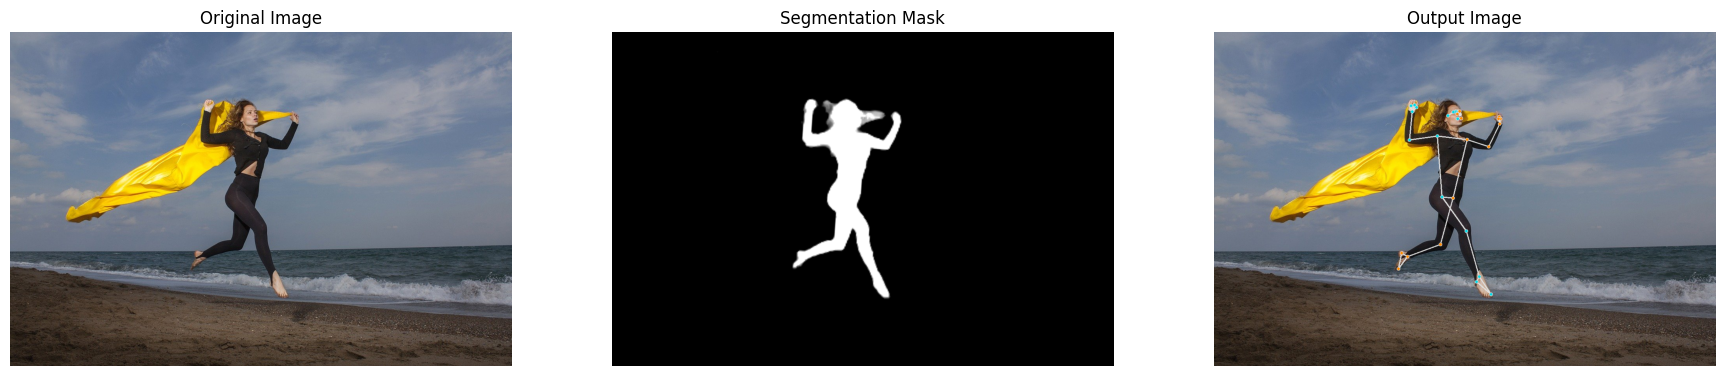

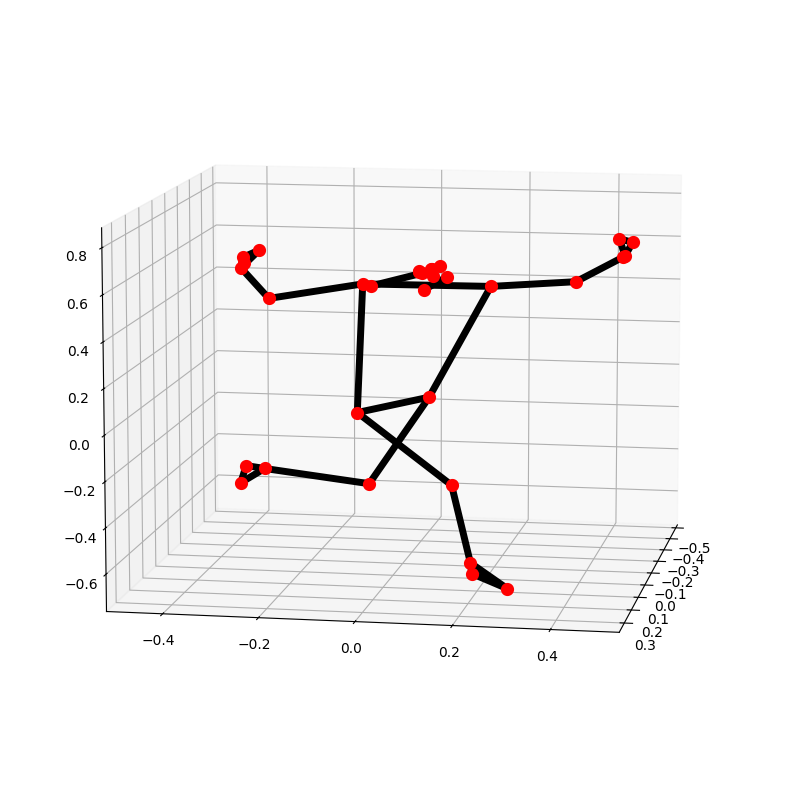

In [ ]:
image = cv2.imread('D:\PracAI Assignment\media\sample3.jpg')
detectPoseLandmarks(image, pose_images, display=True)

Test it on real-time webcam feed

In [ ]:
# Initialize the VideoCapture object to read from the webcam
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes
cv2.namedWindow('Pose Landmarks Detection', cv2.WINDOW_NORMAL)

start_time = time()

frame_count = 0

while camera_video.isOpened():
    
    # Read a frame
    ok, frame = camera_video.read()
    
    if not ok:
        continue
    
    frame_count += 1
        
    frame_height, frame_width, _ = frame.shape
    
    # Flip the frame horizontally for natural (selfie-view) visualization
    frame = cv2.flip(frame, 1)
    
    # Perform pose landmarks detection on the frame.
    frame, _ = detectPoseLandmarks(frame, pose_videos, display=False)
    
    # Calaculate average frames per second
    ##################################################################################################
    
    # Get  current time
    curr_time = time()
    
    # Check if the difference between the start and current time > 0 to avoid division by zero.
    if (curr_time - start_time) > 0:
    
        # Calculate the number of frames per second
        frames_per_second = frame_count // (curr_time - start_time)
        
        # Write the calculated number of fps on the frame
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, int(frame_width/25)),
                    cv2.FONT_HERSHEY_PLAIN, int(frame_width/300), (0, 255, 0), int(frame_width/200))
    
    ##################################################################################################
           
    cv2.imshow('Pose Landmarks Detection', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

camera_video.release()
cv2.destroyAllWindows()